In [69]:
import cv2
import numpy as np
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import os
import plotly
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Load datasets

In [70]:
class Data:
    def __init__(self, path):
        self.path = path
        self.name = None
        self.class_color_mapping = None
        self.class_names = None
        self.imgs = None
        self.instances_map = None
        self.classification_map = None
        self.counts = None
        self.properties = ['area', 'eccentricity', 'perimeter', 'orientation', 'axis_major_length', 'axis_minor_length', 'num_pixels']
        self.relevant_instances = None
        self.all_instances = None

    def get_all_instances(self):
        dfs = [self.instance_properties(idx) for idx in self.relevant_instances]
        all_instances = pd.concat(dfs, ignore_index=True)
        all_instances['dataset'] = self.name
        return all_instances

    def instance_properties(self, n):
        image = self.imgs[n]
        inst_map = self.instances_map[n]
        class_map = self.classification_map[n]

        # Generating unique colours for each class associated with an instance
        mask = inst_map != 0
        instance_ids = inst_map[mask]
        class_ids = class_map[mask]
        instance_class_mapping = dict(zip(instance_ids, class_ids))
        instance_name_mapping = dict(zip(instance_ids, [self.class_names[id] for id in class_ids]))
        table = measure.regionprops_table(inst_map, image, self.properties) #Total properties table
        table['class'] = instance_class_mapping.values()
        table['class_name'] = instance_name_mapping.values()
        df = pd.DataFrame(table)
        return df

    def plot_image(self, n):
        image = self.imgs[n]
        inst_map = self.instances_map[n]
        unique_instances = np.unique(inst_map)[1:]
        class_map = self.classification_map[n]

        # Generating unique colours for each class associated with an instance
        mask = inst_map != 0
        instance_ids = inst_map[mask]
        class_ids = class_map[mask]
        instance_class_mapping = dict(zip(instance_ids, class_ids))

        fig = px.imshow(image, binary_string=True)
        fig.update_traces(hoverinfo='skip') 

        properties = ['area', 'eccentricity', 'perimeter', 'orientation', 'axis_major_length', 'axis_minor_length', 'num_pixels']

        colors_used = {}
        for instance_label in unique_instances:
            mask = np.where(inst_map == instance_label, 255, 0).astype(np.uint8) # Create a mask for the current instances
            contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] # Find contours in the mask
            props = measure.regionprops(mask, image, properties)[0] #Properties for each instance

            # Iterate through contours of the current instance
            for idx, contour in enumerate(contours):
                contour = np.squeeze(contour, axis=1) # Contour in plotly-compatible format
                y, x = contour[:, 1], contour[:, 0]
                
                hoverinfo = ''
                for prop_name in properties:
                    hoverinfo += f'<b>{prop_name}:</b> {getattr(props, prop_name):.2f}<br>' #Hoverinfo text
                
                color = self.class_color_mapping.get(instance_class_mapping[instance_label])
                colors_used[instance_class_mapping[instance_label]] = color

                # Add trace for the contour
                fig.add_trace(go.Scatter(
                    x=x, y=y, mode='lines', fill='toself',
                    line=dict(color=color), 
                    hoveron='points+fills',
                    hovertemplate=hoverinfo,
                    showlegend=False
                ))  
                
        colors_used = dict((v1, v2) for k2,v2 in colors_used.items() for k1,v1 in self.class_names.items() if k1==k2)
            
        for class_id, color in colors_used.items():
            fig.add_trace(go.Scatter(y=[None], mode='markers',
                                marker=dict(size=10, color=color[:3]+'a'+color[3:-1]+', 0.4)', line=dict(color=color, width=6)),
                                marker_symbol='diamond-wide', 
                                name=f"{class_id}",
                                ))

        fig.update_layout(
            showlegend=True,
            legend=dict(
                x=0.75,
                y=0.7,
                traceorder="normal",
                title="",
                itemsizing="constant"
            ),
            # xaxis=dict(visible=False),
            # yaxis=dict(visible=False)
        )

        plotly.io.show(fig)
    


class LizardData(Data):
    def __init__(self, path):
        super().__init__(path)
        self.path = path
        self.name = "LIZARD"
        self.class_color_mapping = {
            1: 'rgb(255, 165, 0)', # Orange
            2: 'rgb(0, 255, 0)',   # Green
            3: 'rgb(255, 0, 0)',   # Red
            4: 'rgb(0, 255, 255)', # Cyan
            5: 'rgb(0, 0, 255)',   # Blue
            6: 'rgb(255, 255, 0)', # Tellow
        }
            
        self.class_names = {
            1: 'NEU', #'Neutrophil',
            2: 'EPI', #'Epithelial',
            3: 'LYM', #'Lymphocyte',
            4: 'PLA', #'Plasma',
            5: 'EOS', #'Eosinophil',
            6: 'CON', #'Connective',
        }
        self.imgs = np.load(self.path + '\images.npy')
        self.instances_map = np.load(self.path + '\labels.npy')[..., 0]
        self.classification_map = np.load(self.path + '\labels.npy')[..., 1]
        self.counts = pd.read_csv(self.path + '\counts.csv')
        self.relevant_instances = self.get_relevant_instances()
        self.all_instances = self.get_all_instances()

    def get_relevant_instances(self):
        relevant_instances = [] # All instances that contain PLA, LYM, EOS and EPI
        for id in range(len(self.instances_map)):
            image = self.imgs[id]
            inst_map = self.instances_map[id]
            class_map = self.classification_map[id]
            mask = inst_map != 0
            class_ids = np.unique(class_map[mask])
            if all(x in class_ids for x in [2, 3, 4, 5, 6]): # Only use representative images that contain PLA, LYM, EOS and EPI cells and thus are similar to ours.
                relevant_instances.append(id)
        return relevant_instances


class LotusData(Data):
    def __init__(self, path):
        super().__init__(path)
        self.path = path
        self.name = "LOTUS"
        self.class_color_mapping = {
            1: 'rgb(0, 255, 0)',   # Green
            2: 'rgb(255, 165, 0)', # Orange
            3: 'rgb(0, 255, 255)', # Cyan
            4: 'rgb(255, 0, 0)',   # Red
            5: 'rgb(0, 0, 255)',   # Blue
            6: 'rgb(255, 255, 0)', # Tellow
        }
            
        self.class_names = {
            1: 'EPI',
            2: 'GOB',
            3: 'PLA',
            4: 'LYM',
            5: 'EOS',
            6: 'FIB',
        }

        self.imgs = self.load_images_as_arrays(os.path.join(path, 'images'))
        self.instances_map = self.load_images_as_arrays(os.path.join(path, 'masks', 'instance_indexing'))
        self.instances_map = [instance_map[:,:,0] for instance_map in self.instances_map] # Needs to be 2D array, mapping 3D grey values (a,a,a) to a.
        self.classification_map = self.load_images_as_arrays(os.path.join(path, 'masks', 'semantic_indexing'))
        self.classification_map = [classification[:,:,0] for classification in self.classification_map] # Needs to be 2D array, mapping 3D grey values (a,a,a) to a.
        self.relevant_instances = self.get_relevant_instances()
        self.all_instances = self.get_all_instances()

    def load_images_as_arrays(self, folder):
            image_arrays = []
            for filename in os.listdir(folder):
                img_path = os.path.join(folder, filename)
                if os.path.isfile(img_path) and img_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif')):
                    img = cv2.imread(img_path)
                    if len(img.shape) == 3:
                        # Convert BGR to RGB as OpenCV loads images in BGR format
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    image_arrays.append(img_rgb)
            return image_arrays
    
    def get_relevant_instances(self):
        relevant_instances = [] # All instances that contain PLA, LYM, EOS and EPI
        for id in range(len(self.instances_map)):
            image = self.imgs[id]
            inst_map = self.instances_map[id]
            class_map = self.classification_map[id]
            mask = inst_map != 0
            class_ids = np.unique(class_map[mask])
            #if all(x in class_ids for x in [1, 2, 3, 4, 5]): # Due to rare cell types not occuring on many synthetic images we consider all images
            relevant_instances.append(id) # Due to rare cell types not occuring on many synthetic images we consider all images
        return relevant_instances



<>:130: SyntaxWarning:

invalid escape sequence '\i'

<>:131: SyntaxWarning:

invalid escape sequence '\l'

<>:132: SyntaxWarning:

invalid escape sequence '\l'

<>:133: SyntaxWarning:

invalid escape sequence '\c'

<>:130: SyntaxWarning:

invalid escape sequence '\i'

<>:131: SyntaxWarning:

invalid escape sequence '\l'

<>:132: SyntaxWarning:

invalid escape sequence '\l'

<>:133: SyntaxWarning:

invalid escape sequence '\c'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_22168\2235646684.py:130: SyntaxWarning:

invalid escape sequence '\i'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_22168\2235646684.py:131: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_22168\2235646684.py:132: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\ckarg\AppData\Local\Temp\ipykernel_22168\2235646684.py:133: SyntaxWarning:

invalid escape sequence '\c'



In [71]:
# NOTE: Takes a couple of minutes to load. Take a break and rethink your life decisions.
lotus = LotusData(r'C:\Users\ckarg\Documents\Datasets\render_v1_7\train')
lizard = LizardData(r'C:\Users\ckarg\Documents\Datasets\HE_lizard\data')

In [72]:
for idx in lotus.relevant_instances[:5]:
    lotus.plot_image(idx)

In [73]:
for idx in lizard.relevant_instances[:5]:
    lizard.plot_image(idx)

In [74]:
lizard.all_instances

area  eccentricity  perimeter  orientation  axis_major_length  \
0       220.0      0.454605  54.384776     0.916958          17.819718   
1       215.0      0.921799  61.698485    -1.248672          26.835580   
2       193.0      0.361722  50.627417     1.064950          16.352615   
3       186.0      0.510893  48.970563    -0.354041          16.627401   
4       177.0      0.957974  65.112698     0.529935          30.047780   
...       ...           ...        ...          ...                ...   
186637  152.0      0.929346  53.112698     0.659967          23.408079   
186638   81.0      0.597922  30.727922     1.558500          11.345227   
186639  113.0      0.762240  38.384776     0.448766          14.981870   
186640   61.0      0.468365  25.899495     1.181583           9.353561   
186641   49.0      0.564604  23.899495    -0.998530           8.720090   

        axis_minor_length  num_pixels  class class_name dataset  
0               15.871898         220      4        PLA  LIZARD  
1               10.403317         215      2        EPI  LIZARD  
2               15.245315         193      2        EPI  LIZARD  
3               14.293648         186      6        CON  LIZARD  
4                8.619328         177      2        EPI  LIZARD  
...                   ...         ...    ...        ...     ...  
186637           8.642496         152      4        PLA  LIZARD  
186638           9.093817          81      3        LYM  LIZARD  
186639           9.697678         113      2        EPI  LIZARD  
186640           8.264199          61      6        CON  LIZARD  
186641           7.197229          49      6        CON  LIZARD  

[186642 rows x 10 columns]

In [75]:
print(len(lotus.relevant_instances))
lotus.all_instances

1792


area  eccentricity   perimeter  orientation  axis_major_length  \
0       539.0      0.441545   85.597980     0.835075          28.027325   
1       374.0      0.827889   75.112698    -1.345481          29.490418   
2       539.0      0.741778   88.769553     0.264211          32.588605   
3       342.0      0.651046   69.941125    -1.474465          24.057390   
4       573.0      0.615714   89.012193    -0.015762          30.690348   
...       ...           ...         ...          ...                ...   
151786  628.0      0.903113  103.597980    -1.408406          43.342888   
151787  444.0      0.857781   82.183766    -1.260091          33.165234   
151788  169.0      0.487939   46.041631    -1.236776          15.710678   
151789  510.0      0.830026   86.769553     1.276874          34.235239   
151790  405.0      0.779620   75.012193    -0.779324          28.738497   

        axis_minor_length  num_pixels  class class_name dataset  
0               25.147218         539      1        EPI   LOTUS  
1               16.540941         374      1        EPI   LOTUS  
2               21.855396         539      1        EPI   LOTUS  
3               18.260476         342      1        EPI   LOTUS  
4               24.183056         573      1        EPI   LOTUS  
...                   ...         ...    ...        ...     ...  
151786          18.611593         628      1        EPI   LOTUS  
151787          17.047418         444      3        PLA   LOTUS  
151788          13.713504         169      1        EPI   LOTUS  
151789          19.093832         510      4        LYM   LOTUS  
151790          17.997572         405      3        PLA   LOTUS  

[151791 rows x 10 columns]

In [76]:
# Convert pixel measures to microns

# Note: Lizard is 0.5 microns per pixel, whereas Lotus is 0.25 microns per pixel

# Lizard
lizard.all_instances['area_in_microns'] = lizard.all_instances['area'] * 0.5 * 0.5
lizard.all_instances['axis_major_length_in_microns'] = lizard.all_instances['axis_major_length'] * 0.5
lizard.all_instances['axis_minor_length_in_microns'] = lizard.all_instances['axis_minor_length'] * 0.5

# Lotus
lotus.all_instances['area_in_microns'] = lotus.all_instances['area'] * 0.25 * 0.25
lotus.all_instances['axis_major_length_in_microns'] = lotus.all_instances['axis_major_length'] * 0.25
lotus.all_instances['axis_minor_length_in_microns'] = lotus.all_instances['axis_minor_length'] * 0.25


 Number of relevant images in Lizard dataset: 1203
 Number of relevant images in Lotus dataset: 1792


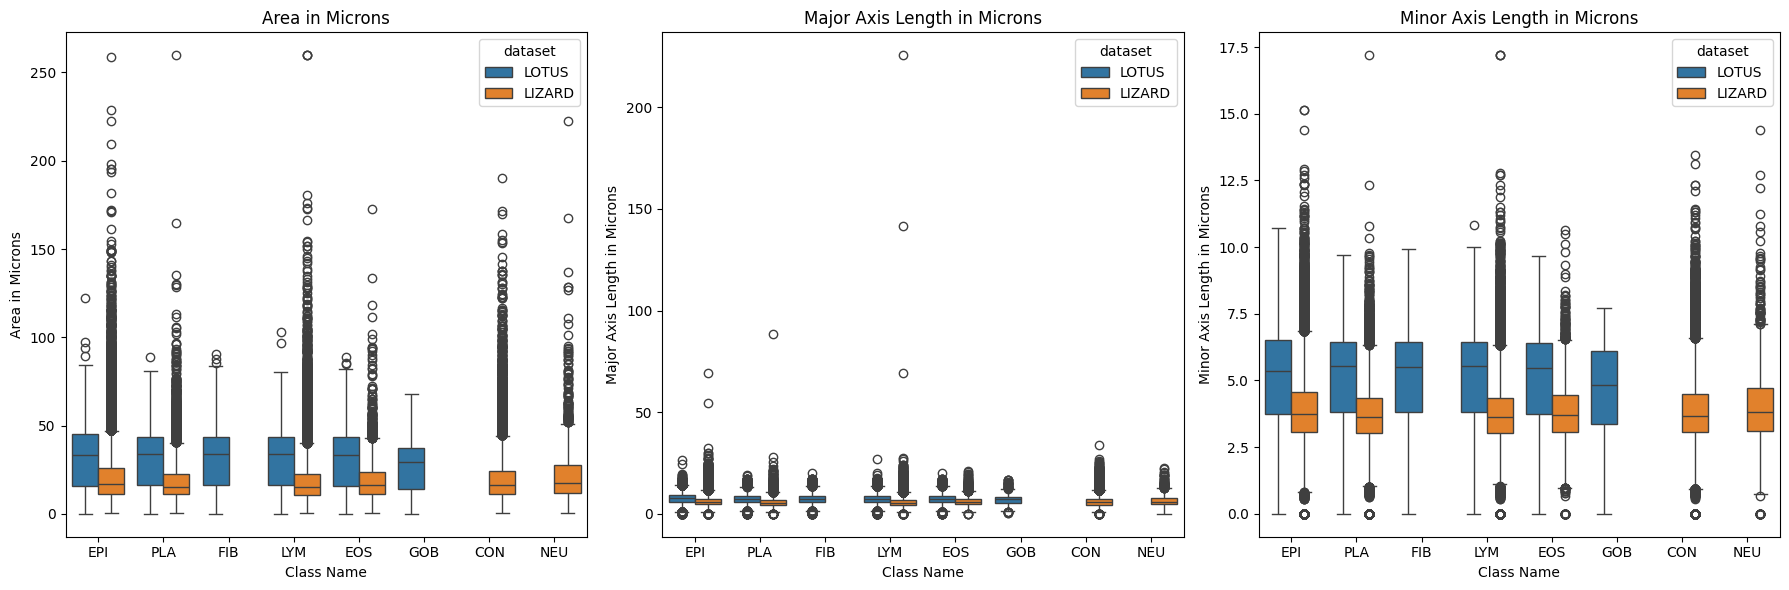

In [93]:
# Compare statistics
total_dfs = [lotus.all_instances, lizard.all_instances]

summary = pd.concat(total_dfs)
num_images_lizard = len(lizard.relevant_instances)
num_images_lotus = len(lotus.relevant_instances)
print(f" Number of relevant images in Lizard dataset: {num_images_lizard}")
print(f" Number of relevant images in Lotus dataset: {num_images_lotus}")

# create grouped boxplot 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of subplots

# Plot for 'area_in_microns'
sns.boxplot(x='class_name', y='area_in_microns', hue='dataset', data=summary, ax=axes[0])
axes[0].set_title('Area in Microns')
axes[0].set_ylabel('Area in Microns')
axes[0].set_xlabel('Class Name')

# Plot for 'axis_major_length_in_microns'
sns.boxplot(x='class_name', y='axis_major_length_in_microns', hue='dataset', data=summary, ax=axes[1])
axes[1].set_title('Major Axis Length in Microns')
axes[1].set_ylabel('Major Axis Length in Microns')
axes[1].set_xlabel('Class Name')

# Plot for 'axis_minor_length_in_microns'
sns.boxplot(x='class_name', y='axis_minor_length_in_microns', hue='dataset', data=summary, ax=axes[2])
axes[2].set_title('Minor Axis Length in Microns')
axes[2].set_ylabel('Minor Axis Length in Microns')
axes[2].set_xlabel('Class Name')

# Adjust layout
plt.tight_layout()
plt.show()

In [94]:
# We now consider cleaned data where we only consider area and axes within 50 and 90 percentile
# We dismiss <50 percentile values since these areas / axes do represent nucleus intersections that do not represent the true diameter of the nucleus.
# We dismiss >90 percentile values since these could represent false merges of two separate instances.

LOWER_PERCENTILE = 80
UPPER_PERCENTILE = 95

def filter_by_percentiles(df, value_column, lower_percentile=50, upper_percentile=90):
    filtered_df = pd.DataFrame()
    # Only keep PLA, LYM, EPI and EOS
    df = df[df['class_name'].isin(['PLA', 'LYM', 'EPI', 'EOS'])]
    grouped = df.groupby('class_name')
    for _, group in grouped:
        # Calculate the percentiles
        lower_bound = group[value_column].quantile(lower_percentile / 100)
        upper_bound = group[value_column].quantile(upper_percentile / 100)
        
        # Filter the group based on the calculated percentiles
        filtered_group = group[(group[value_column] >= lower_bound) & (group[value_column] <= upper_bound)]
        
        # Append the filtered group to the resulting DataFrame
        filtered_df = pd.concat([filtered_df, filtered_group])
    return filtered_df

# Filter the lizard data
lizard_filtered_by_area = filter_by_percentiles(lizard.all_instances, 'area', LOWER_PERCENTILE, UPPER_PERCENTILE)
lizard_filtered_by_major_axis = filter_by_percentiles(lizard.all_instances, 'axis_major_length', LOWER_PERCENTILE, UPPER_PERCENTILE)
lizard_filtered_by_minor_axis = filter_by_percentiles(lizard.all_instances, 'axis_minor_length', LOWER_PERCENTILE, UPPER_PERCENTILE)


# Filter the lotus data
lotus_filtered_by_area = filter_by_percentiles(lotus.all_instances, 'area', LOWER_PERCENTILE, UPPER_PERCENTILE)
lotus_filtered_by_major_axis = filter_by_percentiles(lotus.all_instances, 'axis_major_length', LOWER_PERCENTILE, UPPER_PERCENTILE)
lotus_filtered_by_minor_axis = filter_by_percentiles(lotus.all_instances, 'axis_minor_length', LOWER_PERCENTILE, UPPER_PERCENTILE)

area_summary = pd.concat([lizard_filtered_by_area, lotus_filtered_by_area])
major_axis_summary = pd.concat([lizard_filtered_by_major_axis, lotus_filtered_by_major_axis])
minor_axis_summary = pd.concat([lizard_filtered_by_minor_axis, lotus_filtered_by_minor_axis])

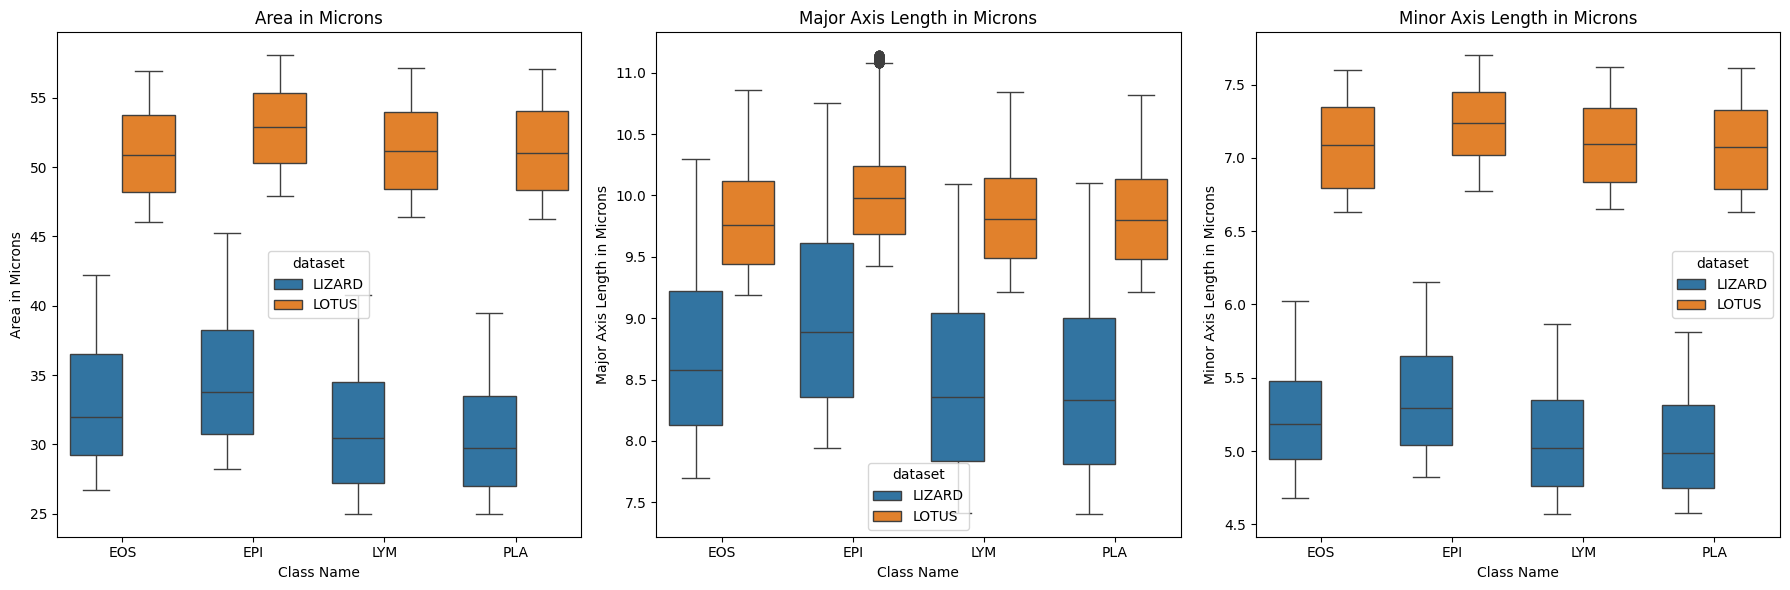

In [95]:
# create grouped boxplot 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of subplots

# Plot for 'area_in_microns'
sns.boxplot(x='class_name', y='area_in_microns', hue='dataset', data=area_summary, ax=axes[0])
axes[0].set_title('Area in Microns')
axes[0].set_ylabel('Area in Microns')
axes[0].set_xlabel('Class Name')

# Plot for 'axis_major_length_in_microns'
sns.boxplot(x='class_name', y='axis_major_length_in_microns', hue='dataset', data=major_axis_summary, ax=axes[1])
axes[1].set_title('Major Axis Length in Microns')
axes[1].set_ylabel('Major Axis Length in Microns')
axes[1].set_xlabel('Class Name')

# Plot for 'axis_minor_length_in_microns'
sns.boxplot(x='class_name', y='axis_minor_length_in_microns', hue='dataset', data=minor_axis_summary, ax=axes[2])
axes[2].set_title('Minor Axis Length in Microns')
axes[2].set_ylabel('Minor Axis Length in Microns')
axes[2].set_xlabel('Class Name')

# Adjust layout
plt.tight_layout()
plt.show()

In [96]:
# Per feature and class compute the ratio of the median feature in the filtered data

# Area
lotus_area = lotus_filtered_by_area.groupby('class_name')['area_in_microns'].median()
lotus_area.name = 'LOTUS: Median area in microns'
lizard_area = lizard_filtered_by_area.groupby('class_name')['area_in_microns'].median()
lizard_area.name = 'LIZARD: Median area in microns'

print('\nArea:')
print(lotus_area)
print(lizard_area)

# Major axis
lotus_major_axis = lotus_filtered_by_major_axis.groupby('class_name')['axis_major_length_in_microns'].median()
lotus_major_axis.name = 'LOTUS: Median major axis length in microns'
lizard_major_axis = lizard_filtered_by_major_axis.groupby('class_name')['axis_major_length_in_microns'].median()
lizard_major_axis.name = 'LIZARD: Median major axis length in microns'

print('\nMajor axis:')
print(lotus_major_axis)
print(lizard_major_axis)

# Minor axis
lotus_minor_axis = lotus_filtered_by_minor_axis.groupby('class_name')['axis_minor_length_in_microns'].median()
lotus_minor_axis.name = 'LOTUS: Median minor axis length in microns'
lizard_minor_axis = lizard_filtered_by_minor_axis.groupby('class_name')['axis_minor_length_in_microns'].median()
lizard_minor_axis.name = 'LIZARD: Median minor axis length in microns'

print('\nMinor axis:')
print(lotus_minor_axis)
print(lizard_minor_axis)


Area:
class_name
EOS    50.87500
EPI    52.87500
LYM    51.15625
PLA    51.00000
Name: LOTUS: Median area in microns, dtype: float64
class_name
EOS    32.00
EPI    33.75
LYM    30.50
PLA    29.75
Name: LIZARD: Median area in microns, dtype: float64

Major axis:
class_name
EOS    9.755666
EPI    9.976147
LYM    9.807081
PLA    9.803765
Name: LOTUS: Median major axis length in microns, dtype: float64
class_name
EOS    8.575241
EPI    8.886957
LYM    8.358662
PLA    8.335198
Name: LIZARD: Median major axis length in microns, dtype: float64

Minor axis:
class_name
EOS    7.085520
EPI    7.236605
LYM    7.094318
PLA    7.075214
Name: LOTUS: Median minor axis length in microns, dtype: float64
class_name
EOS    5.186291
EPI    5.296082
LYM    5.021636
PLA    4.990184
Name: LIZARD: Median minor axis length in microns, dtype: float64


In [99]:
# Compute the scaling factor per featur and class

area_scale = np.sqrt(lotus_area / lizard_area)
area_scale.name = 'Area scaling factor'

major_axis_scale = lotus_major_axis / lizard_major_axis
major_axis_scale.name = 'Major axis scaling factor'

minor_axis_scale = lotus_minor_axis / lizard_minor_axis
minor_axis_scale.name = 'Minor axis scaling factor'

average_scale = (area_scale + major_axis_scale + minor_axis_scale) / 3
average_scale.name = 'Average scaling factor'

scaling_factors_df = pd.concat([area_scale, major_axis_scale, minor_axis_scale, average_scale], axis=1)
print('Scaling factors per feature and cell type')
print('(Corresponds to the ratio: LOTUS median / LIZARD median):')
print("\n")
print(scaling_factors_df)


Scaling factors per feature and cell type
(Corresponds to the ratio: LOTUS median / LIZARD median):


            Area scaling factor  Major axis scaling factor  \
class_name                                                   
EOS                    1.260890                   1.137655   
EPI                    1.251666                   1.122561   
LYM                    1.295088                   1.173284   
PLA                    1.309307                   1.176189   

            Minor axis scaling factor  Average scaling factor  
class_name                                                     
EOS                          1.366202                1.254916  
EPI                          1.366407                1.246878  
LYM                          1.412750                1.293707  
PLA                          1.417826                1.301107  


# Count ratios

In [82]:
# Count rows per class
lizard_counts = lizard.all_instances.groupby('class_name', as_index=False)['area'].count()
lizard_counts['count'] = lizard_counts['area']
lizard_counts['rel_count'] = lizard_counts['count'] / len(lizard.relevant_instances)
lizard_counts['ratio'] = lizard_counts['count'] / lizard_counts['count'].sum()
print(f"Lizard datatset - cell counts in {len(lizard.relevant_instances)} relevant images:")
print(lizard_counts[['class_name', 'count', 'rel_count', 'ratio']])

Lizard datatset - cell counts in 1203 relevant images:
  class_name  count  rel_count     ratio
0        CON  40990  34.073150  0.219618
1        EOS   3260   2.709892  0.017467
2        EPI  73390  61.005819  0.393213
3        LYM  51589  42.883624  0.276406
4        NEU   1700   1.413134  0.009108
5        PLA  15713  13.061513  0.084188


In [83]:
# Count rows per class
lotus_counts = lotus.all_instances.groupby('class_name', as_index=False)['area'].count()
lotus_counts['count'] = lotus_counts['area']
lotus_counts['rel_count'] = lotus_counts['count'] / len(lotus.relevant_instances)
lotus_counts['ratio'] = lotus_counts['count'] / lotus_counts['count'].sum()
print(f"Lotus datatset - cell counts in {len(lotus.relevant_instances)} relevant images:")
print(lotus_counts[['class_name', 'count', 'rel_count', 'ratio']])

Lotus datatset - cell counts in 1792 relevant images:
  class_name  count  rel_count     ratio
0        EOS  13212   7.372768  0.087041
1        EPI  67740  37.801339  0.446272
2        FIB  19147  10.684710  0.126141
3        GOB    690   0.385045  0.004546
4        LYM  32381  18.069754  0.213326
5        PLA  18621  10.391183  0.122675


In [84]:
# Concatentae the ratio columns for izard and lotus for LYM, PLA, EPI and EOS

cell_types = ['PLA', 'LYM', 'EPI', 'EOS']
ratios = {'Class': [], 'Lotus': [], 'Lizard': []}

for cell_type in cell_types:
    lotus_ratio = lotus_counts[lotus_counts['class_name'] == cell_type]['ratio'].values
    lizard_ratio = lizard_counts[lizard_counts['class_name'] == cell_type]['ratio'].values
    ratios['Class'].append(cell_type)
    ratios['Lotus'].append(lotus_ratio[0])
    ratios['Lizard'].append(lizard_ratio[0])

print(f"Lizard vs. Lotus ratios per cell type:")
pd.DataFrame.from_dict(ratios)



Lizard vs. Lotus ratios per cell type:


Class     Lotus    Lizard
0   PLA  0.122675  0.084188
1   LYM  0.213326  0.276406
2   EPI  0.446272  0.393213
3   EOS  0.087041  0.017467